# ACDC Challenge 

In this notebook we will try to obatain the best model for classiying CVD with the use of radiomics data.

We will create a pipeline to work through the data and compare the experiments

In [73]:
### import the packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV, RFE
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Machine Learning Pipeline

1. Dataset 
2. Feature Engineering/Selection
4. ML Algorithms
5. Training and Testing on ACDC Challenge Dataset

### 1. Dataset

We will load the training and test dataset, which contain the extracted radiomics of 100 and 50 patients, respectively. It will also contain the clinical data (only height and weight available) and the class of the patient (each of the 4 diseases or normal state). We will create a function to prepare the datasets.

In [74]:
train_df = pd.read_csv('Extracted_radiomics\ACDC_(Radiomics+Clinical)_Training.csv')
print(train_df.shape)
test_df = pd.read_csv('Extracted_radiomics\ACDC_(Radiomics+Clinical)_Testing.csv')
print(test_df.shape)

(100, 777)
(50, 777)


We know from prior knowledge that both the train and test dataset are equally balanced.

We also know that there are features that are not numeric and are just the product of the of the radiomics library that will not be needed for our model. We show them and we are going to eliminate them.

In [75]:
train_df = train_df.loc[:,~ train_df.columns.str.startswith('diagnostics')]
test_df = test_df.loc[:,~ test_df.columns.str.startswith('diagnostics')]
print(train_df.shape)
print(test_df.shape)

(100, 645)
(50, 645)


In [76]:
y_train = train_df['class']
y_test = test_df['class']

In [77]:
ED_train_df = train_df.filter(regex='ED')
ES_train_df = train_df.filter(regex='ES')

ED_test_df = test_df.filter(regex='ED')
ES_test_df = test_df.filter(regex='ES')

In [78]:
# ED_train_df = pd.concat([ED_train_df, class_df_train], axis=1)
# ES_train_df = pd.concat([ES_train_df, class_df_train], axis=1)

# ED_test_df = pd.concat([ED_test_df, class_df_test], axis=1)
# ES_test_df = pd.concat([ES_test_df, class_df_test], axis=1)

In [79]:
rad_train = pd.concat([ED_train_df, ES_train_df], axis = 1)
rad_test = pd.concat([ED_test_df, ES_test_df], axis = 1)

In [80]:
med_info_train = train_df.iloc[:,-3:-1]
med_info_test = test_df.iloc[:,-3:-1]

In [81]:
all_data_train = pd.concat([rad_train, med_info_train], axis=1)
all_data_test = pd.concat([rad_test, med_info_test], axis=1)

In [82]:
rad_test.shape

(50, 642)

### 2. Feature Engineering/Selection

##### Feature Engineering
* MinMaxScaler for all the features 
* Encoding Class values 

In [83]:
def processing(X_train,y_train, X_test, y_test):
    #tools scaling and labelling
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.fit_transform(y_test)
    
    return X_train, y_train, X_test, y_test

##### Feature Selection

For this section we aim to apply several techiniques for feature selection and compare the performance with each proposed model/learning algorithm of the section 3

Set of Techniques we are going to use:
1. <u> K-Best </u>: This method is a **filter method**, which select features according the K-Highest Score of an statistical Test. For this one we are going to use both **Anova-Test** and **Chi-Suared-Test**.

2. <u> Sequential Forward Feature Elimination </u>: automatically select a subset of features that is most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the generalization error of the model by removing irrelevant features or noise. http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-1-a-simple-sequential-forward-selection-example

#### Models

We combine Feature Selection methods as part of the Grid Search Method

In [84]:
def KBest_GS(X_train, y_train, X_test, y_test, model, param_grid, df):
    
    featss =np.arange(3,X_train.shape[1])
    
    selector = SelectKBest()
    
    ### Pipeline
    
    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"
    
    pipe = Pipeline([('selector', selector), 
                 ('model', model)])
    
    dict_1 = {'selector__score_func': [f_classif, chi2],
              'selector__k':featss}   #### para pruebas
    
    dict_1.update(param_grid)
    
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=dict_1, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=StratifiedKFold(4, shuffle=True, random_state=42),
                  iid=True,
                  refit=True,
                verbose=1)
    
    print(pipe.get_params().keys())
    
    gs = gs.fit(X_train, y_train)
    
    print("Best Model", gs.best_params_)
    
    print('Best score:', gs.best_score_)
    
    y_test_pred = gs.predict(X_test)
    
    test_acc = accuracy_score(y_test,y_test_pred)
    
    print("\n Test Accuracy with best estimator: ", test_acc)
    
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
        
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,4))
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True)
    plt.tight_layout()

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks+0.5, class_list, rotation=45)
    plt.yticks(tick_marks+0.5, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_test_pred,target_names=class_list))
    
    cols = gs.best_estimator_.steps[0][1].get_support(indices=True)
    print(df.iloc[:,cols].columns)
    K_best= df.iloc[:,cols].columns
    
    
    return gs, K_best

---

#### Sequential Foward Selection

In [85]:
# #### Grid Search Sequential Forward Elimination

def SFS_GS(X_train, y_train, X_test, y_test, model, param_grid, df):
    # Setting up the SFS
    sfs1 = SFS(estimator=model,
               k_features=15,
               forward=True,
               floating=False,
               scoring='accuracy',
               cv=StratifiedKFold(3, shuffle=True, random_state=42))

    ### Pipeline

    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"

    pipe = Pipeline([('sfs', sfs1),
                     ('model', model)])

    # dict_1 = {'sfs__k_features':list(range(1,X_train.shape[1]))}   #### para pruebas

    dict_1 = {'sfs__k_features': [5,10]}  # pruebas

    dict_1.update(param_grid)

    gs = GridSearchCV(estimator=pipe,
                      param_grid=dict_1,
                      scoring='accuracy',
                      n_jobs=1,
                      cv=StratifiedKFold(4, shuffle=True, random_state=42),
                      verbose=3,
                      refit=True)

    #     print(pipe.get_params().keys())

    gs = gs.fit(X_train, y_train)

    #     print(gs.best_estimator_.steps)

    print("Best Model", gs.best_params_)

    #     print('Best score:', gs.best_score_)

    y_test_pred = gs.predict(X_test)

    test_acc = accuracy_score(y_test, y_test_pred)

    print("\n Test Accuracy with best estimator: ", test_acc)

    cm = confusion_matrix(y_test, y_test_pred)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 4))

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True)
    plt.tight_layout()

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks+0.5, class_list, rotation=45)
    plt.yticks(tick_marks+0.5, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_test_pred, target_names=class_list))

    feats = gs.best_estimator_.steps[0][1].k_feature_idx_

    feats_2 = np.asanyarray(feats)

    print(df.iloc[:, feats_2].columns)
    feats_names = df.iloc[:, feats_2].columns

    return gs, pipe, feats_names

In [86]:
#ED Alone
X_train_ED, y_train, X_test_ED, y_test = processing(ED_train_df, y_train, ED_test_df, y_test)

#ES Alone

X_train_ES, y_train, X_test_ES, y_test = processing(ES_train_df, y_train, ES_test_df, y_test)

#Radiomics 

X_train_rad, y_train, X_test_rad, y_test = processing(rad_train, y_train, rad_test, y_test)

#All data

X_train_all, y_train, X_test_all, y_test = processing(all_data_train, y_train, all_data_test, y_test)

### 3. ML Algorithms

Let's test some algorithms with the feature selection techniques

In [87]:
#Support Vector Classifier

model_SVC = SVC(gamma = 'scale', max_iter= 5000, random_state=42)

param_grid_SVC =  {'model__kernel':('linear', 'rbf'), 
                   'model__C':[0.5, 1, 10]}

# param_grid_SVC_nested =  { 'sfs__estimator__kernel': ['linear', 'rbf', 'poly']},
#                           {'degree':[1,5,10]},{
#                    'sfs__estimator__C':[5]}

param_grid_SVC_nested_2 =  { 'selector__estimator__kernel': ['linear', 'rbf'],
                   'selector__estimator__C':[15]}

param_grid_SVC_test_2 =  { 
                   'estimator__model__C':[0.5, 1,5,10]}


#-------------------------------------------------------

#Random Forest 

# Number of trees in random forest
n_estimators = [10, 100,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8,10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

param_grid_RF = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

param_grid_RF_nested = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

param_grid_RF_2 = {'estimator__n_estimators': n_estimators,
               'estimator__bootstrap': bootstrap}

model_RF = RandomForestClassifier(random_state=42)

#--------------------------------------------------------------

# Logistic Regression

param_grid_LR_nested = {'model__penalty': ['l1','l2'], 
               'model__C': [0.1,1,10,100, 200]}

param_grid_LR = {'penalty': ['l1','l2'], 
               'C': [0.1,1,10,100, 200]}

model_LR = LogisticRegression( multi_class='auto', random_state=42)

#-------------------------------------------------------------------

### 4. Training and Testing on ACDC Challenge

dict_keys(['memory', 'steps', 'verbose', 'selector', 'model', 'selector__k', 'selector__score_func', 'model__C', 'model__break_ties', 'model__cache_size', 'model__class_weight', 'model__coef0', 'model__decision_function_shape', 'model__degree', 'model__gamma', 'model__kernel', 'model__max_iter', 'model__probability', 'model__random_state', 'model__shrinking', 'model__tol', 'model__verbose'])
Fitting 4 folds for each of 7668 candidates, totalling 30672 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Model {'model__C': 10, 'model__kernel': 'linear', 'selector__k': 88, 'selector__score_func': <function f_classif at 0x00000153FE877D38>}
Best score: 0.9

 Test Accuracy with best estimator:  0.88
[[ 8  0  2  0  0]
 [ 0  9  0  1  0]
 [ 1  0  9  0  0]
 [ 0  1  0  8  1]
 [ 0  0  0  0 10]]


[Parallel(n_jobs=1)]: Done 30672 out of 30672 | elapsed:  3.9min finished
C:\Users\alex1\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


NameError: name 'sns' is not defined

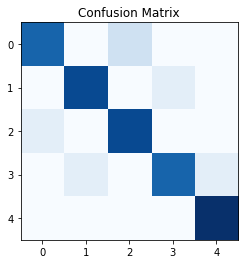

In [88]:
gs, K_best = KBest_GS(X_train_rad, y_train, X_test_rad, y_test, model_SVC, param_grid_SVC, rad_train)